In [1]:
import os
import skimage
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from google.colab import drive
from nibabel.analyze import AnalyzeHeader
import skimage.transform
from PIL import Image
import PIL
from torchvision import transforms
import logging
from collections import namedtuple
from glob import glob
from torch.utils.data import Dataset, DataLoader
import argparse
from PIL import ImageOps, ImageEnhance
import torch
import torchvision.transforms.functional as F
import torch.nn.functional as nnf
from PIL.Image import BILINEAR
import random

In [2]:
def normalize(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image.astype('float32')

class MRIDataset(Dataset):
    def __init__(self, root, transform=None, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        image = image.swapaxes(0,1)
        image = image[:, ::-1]
        image = image[slice_number]
        image = normalize(image)

        if self.transform is not None:
            target = torch.Tensor((image-self.transform.transforms[-1].mean[0])/
                                    self.transform.transforms[-1].std[0])
            tf_image = self.transform(image)
        else: 
            return image
            
        return tf_image, target

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data=MRIDataset("/content/drive/MyDrive/LPBA40/native_space")

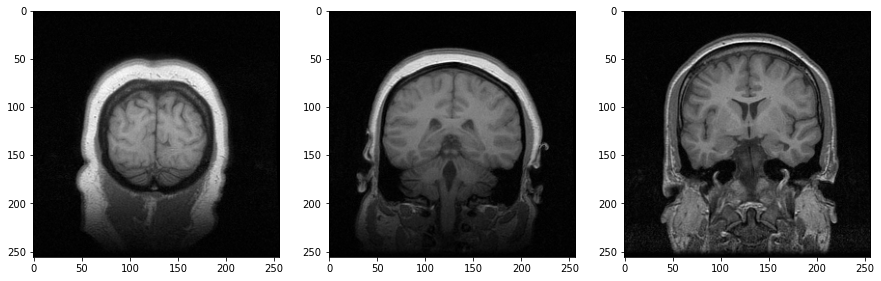

In [5]:
f, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(15,10))
ax0.imshow(data[20], cmap='gray')
ax1.imshow(data[49], cmap='gray')
ax2.imshow(data[789], cmap='gray')

In [6]:
tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(45, (0.2,0.2), (0.6,0.9), 5, Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.1408],[0.1716])
])

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:1418: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


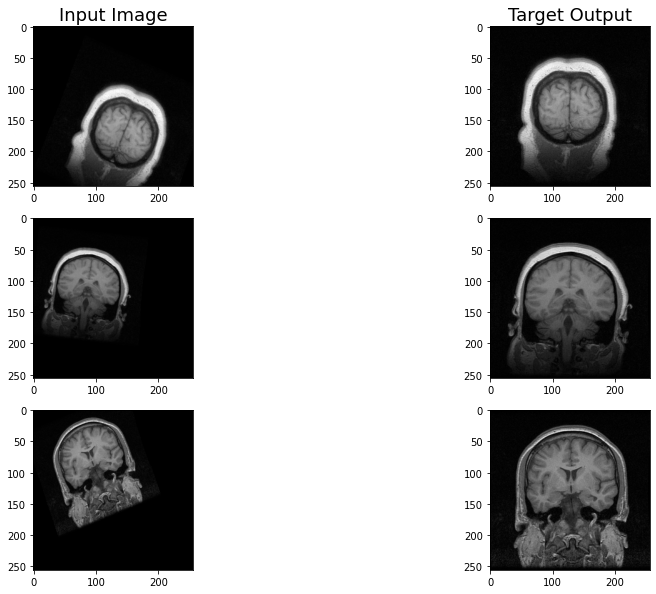

In [7]:
data=MRIDataset("/content/drive/MyDrive/LPBA40/native_space", tfms)
f, (ax0,ax1,ax2) = plt.subplots(3,2,figsize=(15,10))
ax0[0].set_title("Input Image", fontsize=18)
ax0[0].imshow(data[20][0].numpy().squeeze(), cmap='gray')
ax1[0].imshow(data[49][0].numpy().squeeze(), cmap='gray')
ax2[0].imshow(data[789][0].numpy().squeeze(), cmap='gray')

ax0[1].set_title("Target Output", fontsize=18)
ax0[1].imshow(data[20][1].numpy().squeeze(), cmap='gray')
ax1[1].imshow(data[49][1].numpy().squeeze(), cmap='gray')
ax2[1].imshow(data[789][1].numpy().squeeze(), cmap='gray')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bs = 32
dl = DataLoader(data, batch_size=bs,
                        shuffle=True, num_workers=4)

In [ ]:
a=next(iter(dl))
a[0].shape, a[1].shape

(torch.Size([32, 1, 256, 256]), torch.Size([32, 256, 256]))

In [ ]:
a[0].mean(), a[0].std(), a[0].max()

(tensor(-0.2727), tensor(1.0044), tensor(4.9229))

In [ ]:
a[1].mean(), a[1].std(), a[1].max()

(tensor(0.1372), tensor(1.1740), tensor(5.0070))

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5, stride=2),
            nn.ReLU(True)
        )
        self.output_size = ((image_size-7)//2+1-5)//2+1

        self.fc_loc = nn.Sequential(
            nn.Linear(10 * self.output_size**2, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
       
        self.conv1 = nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)
        self.conv1.weight.data.zero_()

    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * self.output_size**2)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        res_out = self.conv1(x)
        x = x + res_out
        
        return x

model = Net(256).to(device)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.005)
loss_fn = nn.L1Loss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(dl):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 50*bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dl.dataset),
                100. * batch_idx / len(dl), loss.item()))


In [ ]:
def convert_image_np(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1408])
    std = np.array([0.1716])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        data = next(iter(dl))
        moving, target = data[0].to(device), data[1].cpu()

        input_tensor = moving.cpu()
        transformed_input_tensor = model(moving).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        
        target_grid = convert_image_np(
            torchvision.utils.make_grid(target[:,None]))
 
        f, axarr = plt.subplots(3, 1, figsize=(24,24))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Moving Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Output Images')
        
        axarr[2].imshow(target_grid)
        axarr[2].set_title('Target Images')

In [ ]:
for epoch in range(1, 20):
    train(epoch)

Train Epoch: 1 [0/4800 (0%)]	Loss: 0.875199
Train Epoch: 1 [1600/4800 (33%)]	Loss: 0.811267
Train Epoch: 1 [3200/4800 (67%)]	Loss: 0.772107
Train Epoch: 2 [0/4800 (0%)]	Loss: 0.763702
Train Epoch: 2 [1600/4800 (33%)]	Loss: 0.741129
Train Epoch: 2 [3200/4800 (67%)]	Loss: 0.744050
Train Epoch: 3 [0/4800 (0%)]	Loss: 0.814162
Train Epoch: 3 [1600/4800 (33%)]	Loss: 0.693921
Train Epoch: 3 [3200/4800 (67%)]	Loss: 0.762855
Train Epoch: 4 [0/4800 (0%)]	Loss: 0.728916
Train Epoch: 4 [1600/4800 (33%)]	Loss: 0.742648
Train Epoch: 4 [3200/4800 (67%)]	Loss: 0.656799
Train Epoch: 5 [0/4800 (0%)]	Loss: 0.698156
Train Epoch: 5 [1600/4800 (33%)]	Loss: 0.690534
Train Epoch: 5 [3200/4800 (67%)]	Loss: 0.722207
Train Epoch: 6 [0/4800 (0%)]	Loss: 0.699732
Train Epoch: 6 [1600/4800 (33%)]	Loss: 0.714950
Train Epoch: 6 [3200/4800 (67%)]	Loss: 0.704618
Train Epoch: 7 [0/4800 (0%)]	Loss: 0.698246
Train Epoch: 7 [1600/4800 (33%)]	Loss: 0.731761
Train Epoch: 7 [3200/4800 (67%)]	Loss: 0.692293
Train Epoch: 8 [0/48

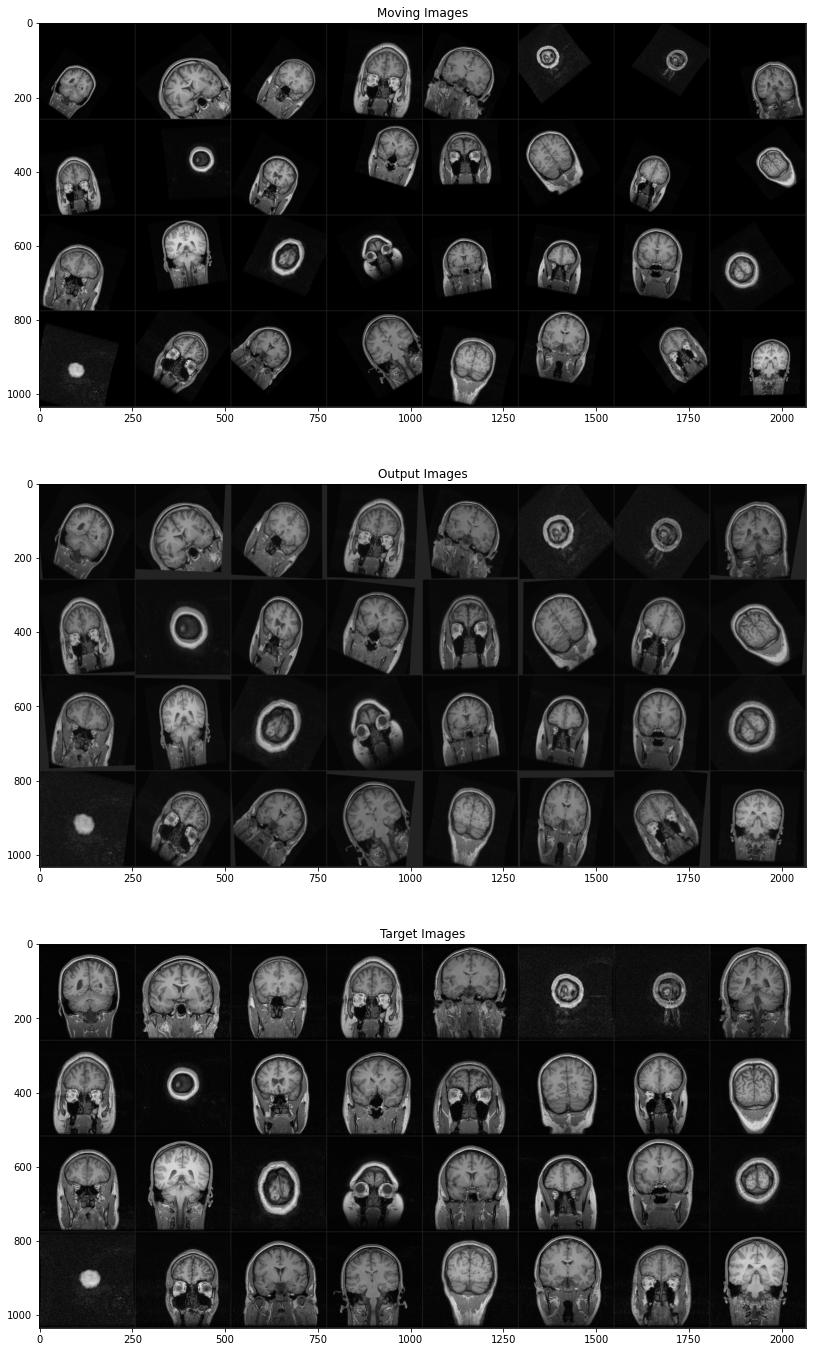

In [ ]:
visualize_stn()

In [ ]:
class MRIMaskDataset(Dataset):
    def __init__(self, root, transform, n_slices=120):
        self.transform = transform
        self.root = root
        self.n_slices = n_slices
        
    def __len__(self):
        return len(os.listdir(self.root))*self.n_slices
    
    def __getitem__(self, idx): 
        subdir = os.listdir(self.root)[idx//self.n_slices]
        slice_number = idx % self.n_slices
    
        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        image_shape = hdr.get_data_shape()
        width, height, depth, _ = image_shape

        f = open(f'{self.root}/{subdir}/{subdir}.native.mri.img', 'rb')
        raw_image = np.fromfile(f, np.uint16)
        image = raw_image.reshape(image_shape).squeeze()
        
        image = image[::-1]
        image = image.swapaxes(0,1)
        image = image[slice_number]
        image = normalize(image)

        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.hdr', 'rb')
        binblock = f.read()
        hdr = AnalyzeHeader(binblock)

        mask_shape = hdr.get_data_shape()
        width, height, depth, _ = mask_shape
        
        f = open(f'{self.root}/{subdir}/{subdir}.native.brain.mask.img', 'rb')
        raw_mask = np.fromfile(f, np.uint8)
        mask = raw_mask.reshape(mask_shape).squeeze()
        
        mask = mask[::-1]
        mask = mask.swapaxes(0,1)
        mask = mask[slice_number]
        mask = mask.astype("float32")
        mask /= 255
            
        moving = self.transform({"image": image, "mask": mask})
            
        return moving["image"], moving["target"], moving["mask"], torch.Tensor(mask)

In [ ]:
import torchvision.transforms.functional as TF
import random
from torchvision.transforms import InterpolationMode

In [ ]:
def mask_transforms(data):
    assert "image" in data and "mask" in data
    
    angle = random.randint(-25,25)
    trans_x = random.random()*0.4-0.2
    trans_y = random.random()*0.4-0.2
    scale = random.random()*0.25 + 0.7
    shear = random.random()*10-5
    
    image = TF.to_pil_image(data["image"])
    image = TF.affine(image, angle, (trans_x,trans_y), scale, shear, InterpolationMode.BILINEAR)
    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.1408],[0.1716])
    
    mask = TF.to_pil_image(data["mask"].astype("float32"))
    mask = TF.affine(mask, angle, (trans_x, trans_y), scale, shear, InterpolationMode.BILINEAR)
    mask = TF.to_tensor(mask)
    
    target = TF.to_tensor(data["image"])
    target = TF.normalize(target, [0.1408],[0.1716])
    
    return {"image": image, "mask":mask, "target":target}

In [ ]:
data = MRIMaskDataset("/content/drive/MyDrive/LPBA401/native_space", mask_transforms)

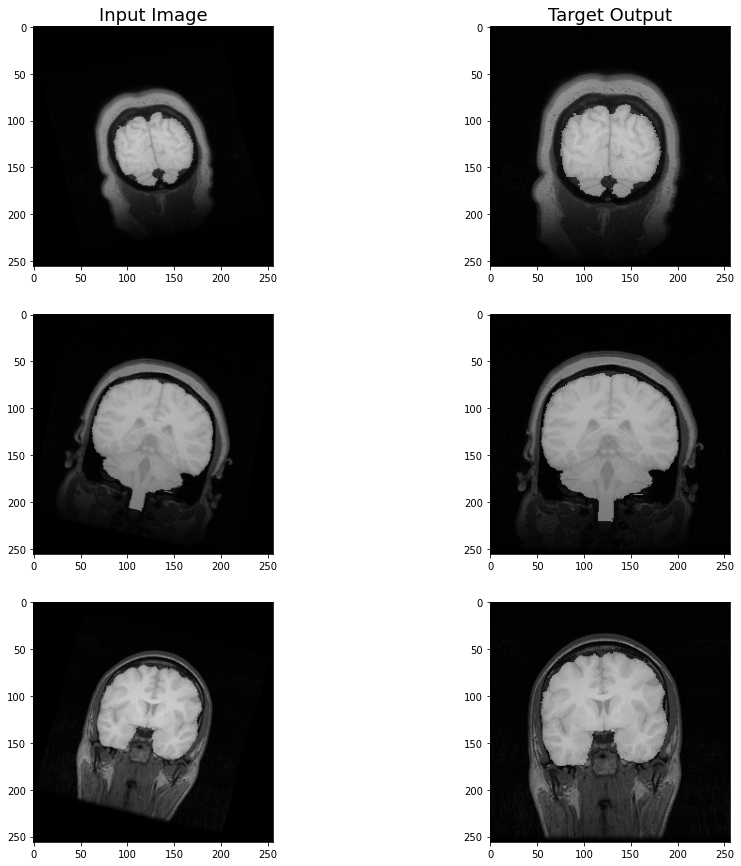

In [ ]:
f, (ax0, ax1, ax2) = plt.subplots(3, 2, figsize=(15, 15))

im1 = data[20]
im2 = data[49]
im3 = data[789]

ax0[0].set_title("Input Image", fontsize=18)
ax0[0].imshow(im1[0].numpy().squeeze(), cmap='gray')
ax1[0].imshow(im2[0].numpy().squeeze(), cmap='gray')
ax2[0].imshow(im3[0].numpy().squeeze(), cmap='gray')

ax0[1].set_title("Target Output", fontsize=18)
ax0[1].imshow(im1[1].numpy().squeeze(), cmap='gray')
ax1[1].imshow(im2[1].numpy().squeeze(), cmap='gray')
ax2[1].imshow(im3[1].numpy().squeeze(), cmap='gray')

ax0[0].imshow(im1[2].numpy().squeeze(), alpha=0.4, cmap='gray')
ax1[0].imshow(im2[2].numpy().squeeze(), alpha=0.4, cmap='gray')
ax2[0].imshow(im3[2].numpy().squeeze(), alpha=0.4, cmap='gray')

ax0[1].imshow(im1[3].numpy().squeeze(), alpha=0.4, cmap='gray')
ax1[1].imshow(im2[3].numpy().squeeze(), alpha=0.4, cmap='gray')
ax2[1].imshow(im3[3].numpy().squeeze(), alpha=0.4, cmap='gray')

In [ ]:
bs = 128
data = MRIMaskDataset("/content/drive/MyDrive/LPBA401/native_space", mask_transforms)
dl = DataLoader(data, batch_size=bs, shuffle=True, num_workers=2)

In [ ]:
class Net(nn.Module):
    def __init__(self, image_size):
        super(Net, self).__init__()

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5, stride=2),
            nn.ReLU(True)
        )
        self.output_size = ((image_size-7)//2+1-5)//2+1

        self.fc_loc = nn.Sequential(
            nn.Linear(10 * self.output_size**2, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        

        self.conv1 = nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)
        self.conv1.weight.data.zero_()

    def forward(self, x, mask):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * self.output_size**2)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners=True)
        mask = F.grid_sample(mask, grid, align_corners=True)
        
        return x, mask

model = Net(256).to(device)

In [ ]:
from sklearn.metrics import jaccard_score

def accuracy(input, target):
    return 1-torch.sum(abs(input.view(-1)-target.view(-1)))/torch.sum(target)

def binarise(mask):
    mask[mask>0.5] = 1
    mask[mask<=0.5] = 0
    return mask

def jaccard_coeff(x, target):
    target = binarise(target.numpy().ravel())
    x = binarise(x.numpy().ravel())
    return jaccard_score(target, x)

def mutual_information(slice1, slice2, n_bins=20):

    hgram, _, _ = np.histogram2d(
                        slice1.numpy().ravel(),
                        slice2.numpy().ravel(),
                        bins=n_bins)

    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0) 
    px_py = px[:, None] * py[None, :] 
    nzs = pxy > 0 
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [ ]:
optimizer = optim.Adam(model.parameters())

loss_fn = nn.MSELoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,5)

def train(epoch):
    losses = []
    model.train()
    for batch_idx, (data, target, input_mask, target_mask) in enumerate(dl):
        data, target = data.to(device), target.to(device)
        input_mask, target_mask =  input_mask.to(device), target_mask.to(device)

        optimizer.zero_grad()
        output_image, output_mask = model(data, input_mask)

        loss = loss_fn(output_image, target)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        if batch_idx  == 0:
            print(f'Train Epoch {epoch}:\t Loss: {round(loss.item(),4)}\t Mask accuracy: {round(accuracy(output_mask,target_mask).item()*100,2)}%\t Jaccard: {round(jaccard_coeff(output_mask.detach().cpu(), target_mask.detach().cpu()),4)}\t MI: {round(mutual_information(output_image.detach().cpu(), target.detach().cpu()), 4)}')
        if batch_idx%2400 == 0:
            losses.append(loss.item())
            
    return losses

In [ ]:
losses = []
for epoch in range(1, 20):
    losses += train(epoch)

Train Epoch 1:	 Loss: 1.109	 Mask accuracy: 65.18%	 Jaccard: 0.6571	 MI: 0.3095
Train Epoch 2:	 Loss: 0.6979	 Mask accuracy: 81.79%	 Jaccard: 0.827	 MI: 0.4706
Train Epoch 3:	 Loss: 0.6253	 Mask accuracy: 83.3%	 Jaccard: 0.8428	 MI: 0.5249
Train Epoch 4:	 Loss: 0.5911	 Mask accuracy: 82.19%	 Jaccard: 0.8324	 MI: 0.5573
Train Epoch 5:	 Loss: 0.5918	 Mask accuracy: 84.07%	 Jaccard: 0.8458	 MI: 0.54
Train Epoch 6:	 Loss: 0.3388	 Mask accuracy: 91.54%	 Jaccard: 0.9193	 MI: 0.7062
Train Epoch 7:	 Loss: 0.2941	 Mask accuracy: 91.45%	 Jaccard: 0.9211	 MI: 0.739
Train Epoch 8:	 Loss: 0.2956	 Mask accuracy: 92.47%	 Jaccard: 0.9294	 MI: 0.754
Train Epoch 9:	 Loss: 0.2932	 Mask accuracy: 92.07%	 Jaccard: 0.9261	 MI: 0.7695
Train Epoch 10:	 Loss: 0.2457	 Mask accuracy: 93.2%	 Jaccard: 0.9371	 MI: 0.8287
Train Epoch 11:	 Loss: 0.2896	 Mask accuracy: 92.53%	 Jaccard: 0.9287	 MI: 0.7528
Train Epoch 12:	 Loss: 0.3409	 Mask accuracy: 91.04%	 Jaccard: 0.919	 MI: 0.7577
Train Epoch 13:	 Loss: 0.287	 Mask

In [ ]:
def convert_image_np(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1408])
    std = np.array([0.1716])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        dl = DataLoader(data, batch_size=16, shuffle=True, num_workers=4)        
        moving, target, input_mask, target_mask = next(iter(dl))
        moving, target = moving.to(device), target.cpu()
        input_mask, target_mask =  input_mask.to(device), target_mask.cpu()

        input_tensor = moving.cpu()
        transformed_input_tensor, transformed_mask = model(moving, input_mask)
        transformed_input_tensor, transformed_mask = transformed_input_tensor.cpu(), transformed_mask.cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))
        in_mask = torchvision.utils.make_grid(input_mask.cpu())

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        out_mask = torchvision.utils.make_grid(transformed_mask)
        
        target_grid = convert_image_np(
            torchvision.utils.make_grid(target))
        target_mask = torchvision.utils.make_grid(target_mask[:, None])

        f, axarr = plt.subplots(4, 1, figsize=(24,24))
        axarr[0].imshow(in_grid)
        axarr[0].imshow(in_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[0].set_title('Moving Images')

        axarr[1].imshow(out_grid)
        axarr[1].imshow(target_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[1].set_title('Output Images with Target Masks')
        
        axarr[2].imshow(target_grid)
        axarr[2].imshow(out_mask.sum(0), alpha=0.5, cmap="copper")
        axarr[2].set_title('Target Images with Output masks')
        
        axarr[3].imshow(target_mask.sum(0), cmap="Reds")
        axarr[3].imshow(out_mask.sum(0), alpha=0.5, cmap="Blues")
        axarr[3].set_title('Target (Red) vs Output Masks (Blue)')

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


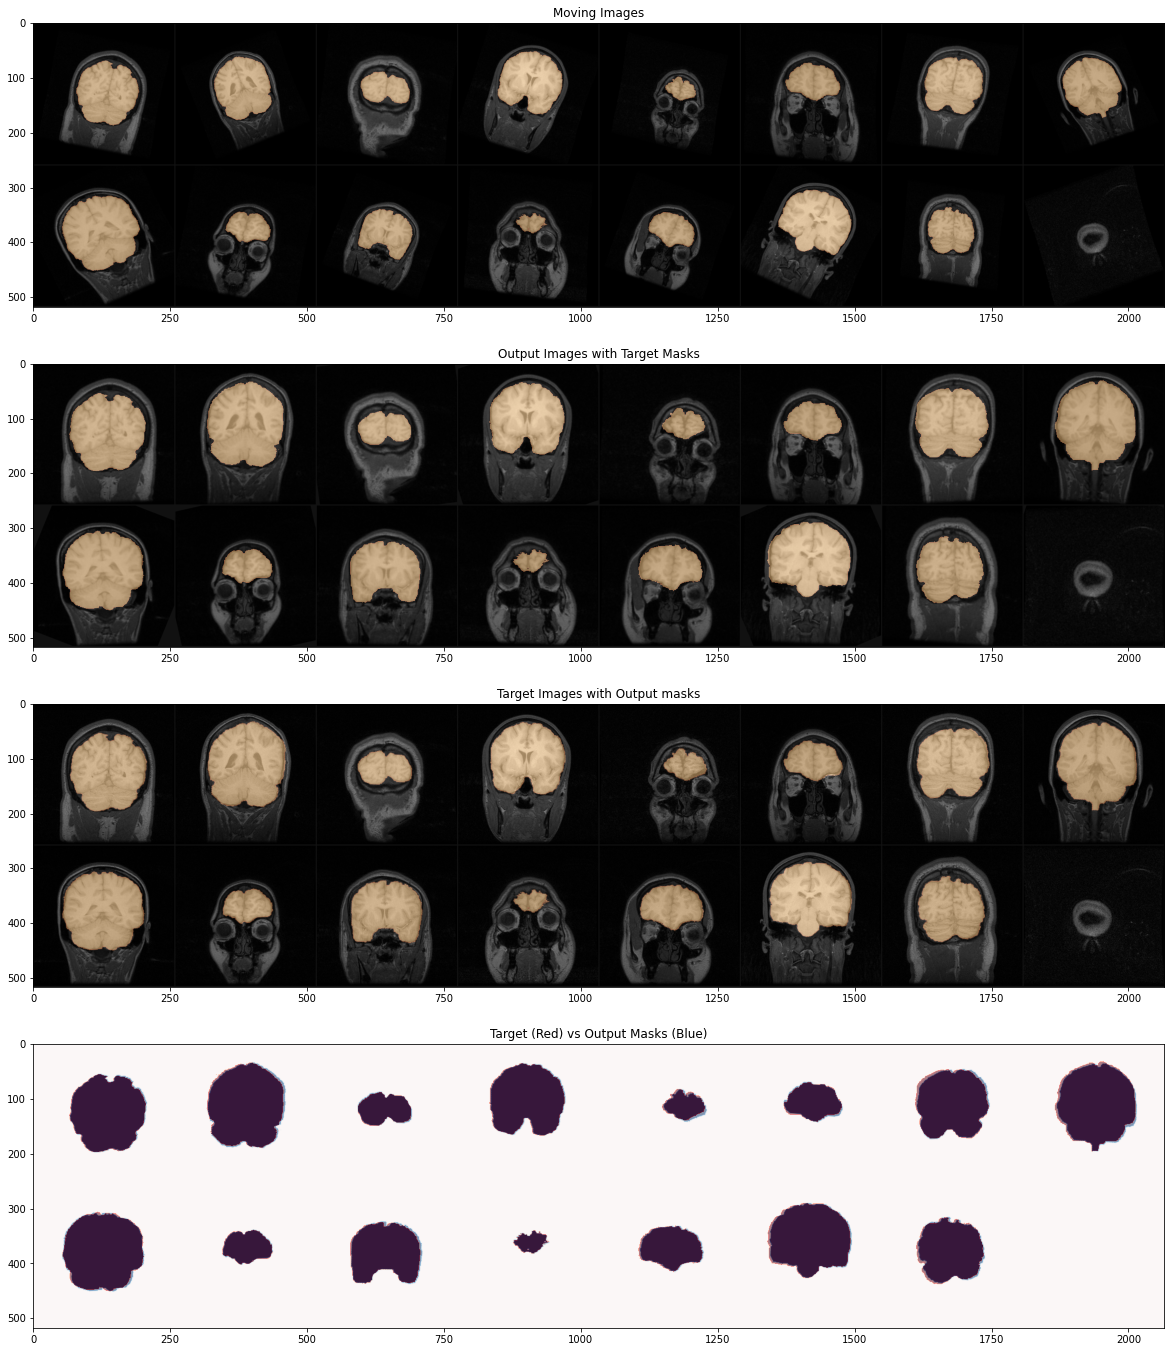

In [ ]:
visualize_stn()